In [1]:
# setup
from load_feature import load_features
from datetime import datetime
from LSTM_model import video_classification
import numpy as np
import os
from keras import optimizers

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


# Load features

In [2]:
# load features for different number of frames
skipnum = 0
num_frames = 15
size = (224, 224, 3)
# num_videos = 1000

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)
tic = datetime.now()
Xtrain, ytrain = load_features(num_videos, num_frames, video_idx = Xtrain_idx, \
                               labels = labels, size = size, train_test_flag='train')
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/train_num_videos4270_num_frame15.npz
Feature fusion time:  0:00:19.581723


In [3]:
print('Xtrain shape: ', Xtrain.shape)
print('ytrain shape: ', ytrain.shape)

Xtrain shape:  (64050, 7, 7, 512)
ytrain shape:  (4270,)


# Other data

In [29]:
np.save(os.getcwd() + '/datasets/Xtrain_lstm_1000.npy', Xtrain)
np.save(os.getcwd() + '/datasets/ytrain_lstm_1000.npy', ytrain)

In [2]:
# small dataset 1000 videos with 20 frames
Xtr = np.load(os.getcwd() + '/datasets/Xtrain_lstm_1000.npy')
ytr = np.load(os.getcwd() + '/datasets/ytrain_lstm_1000.npy')

In [3]:
# pretrained data 10 frames in order to compare with temporal max pooling architecture
Xtr = np.load(os.getcwd() + '/datasets/pretrained_fuse_features.npy')
ytr = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')
print('Xtrain shape: ', Xtr.shape)
print('ytrain shape: ', ytr.shape)

Xtrain shape:  (4270, 10, 7, 7, 512)
ytrain shape:  (4270,)


# LSTM model

In [4]:
# build up model 
num_classes = len(np.unique(ytrain))
lstm = video_classification(num_frames=15, num_classes=num_classes)

# cell_num depends on volume of datasets
lstm.build_model(cell_num = 256, dropout_rate=0.5, reg=0.1)
print('LSTM model summary: ')
print(lstm.model.summary())

building model...
LSTM model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 256)           25953280  
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 27,006,474
Trainable params: 27,006,474
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# sgd_m = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6)
lstm.train(Xtr=Xtrain, ytr=ytrain, optimizer = adam, verbose=1, bsize=64, epochs=20, split_ratio=0.1)

Model is Training...
Train on 3843 samples, validate on 427 samples
Epoch 1/20


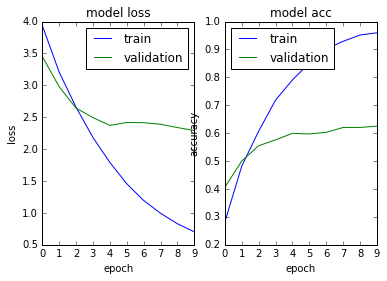

In [24]:
lstm.plot()

In [25]:
# test data loader
num_videos_test = 500
skipnum = 0
num_frames = 15
size = (224, 224, 3)

# load test index
Xtest_idx = np.load(os.getcwd() + '/datasets/x_test_ind_above400.npy')
yte = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

tic = datetime.now()
Xte, yte = load_features(num_videos = num_videos_test, num_frames = num_frames, size = size, \
                             video_idx = Xtest_idx, labels = yte, train_test_flag='test')
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/test_num_videos500_num_frame15.npz
Feature fusion time:  0:00:03.770452


In [29]:
Xte = Xte.reshape((-1, 15, 7*7*512))
lstm.predict(Xte, yte)

Video Classification Accuracy: 0.6027944111776448


In [30]:
from sklearn.metrics import classification_report
from pprint import pprint
ypred = lstm.model.predict(Xte)
ypred = np.argmax(ypred, axis = 1)
target_names = ['music', 'gaming', 'sports/actions', 'news/events/politics', 'movie/comedy', 'vehicles/autos',\
           'howto', 'animals/pets', 'kids/family', 'food/drink']
print(classification_report(yte, ypred, target_names = target_names))

                      precision    recall  f1-score   support

               music       0.50      0.44      0.47        54
              gaming       0.54      0.73      0.62        37
      sports/actions       0.82      0.62      0.71        76
news/events/politics       0.45      0.40      0.42        35
        movie/comedy       0.51      0.54      0.52        68
      vehicles/autos       0.68      0.84      0.75        62
               howto       0.57      0.53      0.55        43
        animals/pets       0.64      0.68      0.66        41
         kids/family       0.46      0.47      0.47        36
          food/drink       0.73      0.67      0.70        49

         avg / total       0.61      0.60      0.60       501



# Other test data

In [30]:
np.save(os.getcwd() + '/datasets/Xte_lstm_1000.npy', Xte)
np.save(os.getcwd() + '/datasets/yte_lstm_1000.npy', yte)

In [29]:
# test accuracy
Xte = np.load(os.getcwd() + '/datasets/Xte_lstm_1000.npy')
yte = np.load(os.getcwd() + '/datasets/yte_lstm_1000.npy')

In [7]:
# pretrained data 10 frames
Xte = np.load(os.getcwd() + '/datasets/pretrained_fuse_Xtest.npy')
yte = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')